**A Comparative Study of Transformer Models for Natural Language to SQL Conversion**

In [1]:
!pip install --upgrade transformers
!pip install transformers datasets --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 50.5 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.2
    Uninstalling transformers-4.52.2:
      Successfully uninstalled transformers-4.52.2


Loading synthetic data for text to SQL training

In [2]:
# Install dependencies
!pip install transformers datasets evaluate -q

# --- Load Data ---
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Load your dataset: it should have 'question' and 'query' columns
data = pd.read_csv("/content/text_to_sql_dataset.csv")  # replace with your actual dataset

# Split
train_df, val_df = train_test_split(data, test_size=0.1, random_state=42)
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.8 MB/s eta 0:00:00


Tokenization

This code defines a function tokenize_function that tokenizes 'question' and 'query' text using a given tokenizer, preparing them for sequence-to-sequence models. It truncates to 128 tokens and pads to ensure uniform length, storing tokenized 'query' as labels within model inputs.



In [3]:
from transformers import DataCollatorForSeq2Seq

# Tokenization function
def tokenize_function(example, tokenizer):
    model_inputs = tokenizer(example['question'], max_length=128, truncation=True, padding="max_length")
    labels = tokenizer(example['query'], max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [4]:
from transformers import Trainer, TrainingArguments
import torch

def train_model(model_name, model_class, tokenizer_class, train_dataset, val_dataset, save_dir):
    tokenizer = tokenizer_class.from_pretrained(model_name)
    model = model_class.from_pretrained(model_name)

    tokenized_train = train_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)
    tokenized_val = val_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)

    data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

    args = TrainingArguments(
        output_dir=save_dir,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=5,
        save_total_limit=1,
        save_steps=500,
        logging_dir=f"{save_dir}/logs",
        logging_steps=100,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    trainer.train()
    trainer.save_model(save_dir)
    return tokenizer, model

This code imports necessary components from the transformers library and then trains two sequence-to-sequence models (T5 and BART) for natural language to SQL conversion using the train_model function. It initializes and trains both models with their respective tokenizers, model architectures, datasets, and designated output model names.

In [5]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, BartTokenizer, BartForConditionalGeneration

# Train T5
t5_tokenizer, t5_model = train_model(
    "t5-small", T5ForConditionalGeneration, T5Tokenizer,
    train_dataset, val_dataset, "t5_sql_model"
)

# Train BART
bart_tokenizer, bart_model = train_model(
    "facebook/bart-base", BartForConditionalGeneration, BartTokenizer,
    train_dataset, val_dataset, "bart_sql_model"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

<ipython-input-4-ee549d6ccf71>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sanikautkr23 (sanikautkr23-college) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
100,2.218100
200,0.213400
300,0.066900
400,0.029100
500,0.018000
600,0.012900
700,0.010500
800,0.008900
900,0.007900
1000,0.007400


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

<ipython-input-4-ee549d6ccf71>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,2.977800
200,0.007300
300,0.003000
400,0.000700
500,0.000800
600,0.000500
700,0.000600
800,0.000600
900,0.000600
1000,0.000700


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3464: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


This code defines a generate function that uses a model and tokenizer to predict SQL queries from questions and then evaluates these predictions on a small batch of examples. It prints the original questions, T5 predictions, and BART predictions for comparison.

In [6]:
def generate(model, tokenizer, question):
    inputs = tokenizer(question, return_tensors="pt", truncation=True, padding=True).to(model.device)
    outputs = model.generate(**inputs, max_length=128)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Evaluate on a small batch
print(f"{'Question':<50} | {'T5 Prediction':<50} | {'BART Prediction'}")
print("-" * 130)
for i in range(10):  # Show 10 examples
    q = val_df.iloc[i]['question']
    gold = val_df.iloc[i]['query']
    t5_pred = generate(t5_model, t5_tokenizer, q)
    bart_pred = generate(bart_model, bart_tokenizer, q)
    print(f"{q:<50} | {t5_pred:<50} | {bart_pred}")

Question                                           | T5 Prediction                                      | BART Prediction
----------------------------------------------------------------------------------------------------------------------------------


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Show all amount values from the payments table.    | SELECT amount FROM payments;                       | SELECT amount FROM payments;
Get the signup_date from customers along with matching credits from courses. | SELECT customers.signup_date, courses.credits FROM customers JOIN courses ON customers.id = courses.id; | SELECT customers.signup_date, courses.credits FROM customers JOIN courses ON customers.id = courses.id;
Show all email values from the customers table.    | SELECT email FROM customers;                       | SELECT email FROM customers;
Show all id values from the courses table.         | SELECT id FROM courses;                            | SELECT id FROM courses;
Show all id values from the departments table.     | SELECT id FROM departments;                        | SELECT id FROM departments;
Show all salary values from the employees table.   | SELECT salary FROM employees;                      | SELECT salary FROM employees;
Show all major values from the students t

This code defines a function compute_accuracy to calculate the accuracy of a model's SQL predictions against a dataset, and then it applies this function to both the T5 and BART models. Finally, it prints the calculated accuracies for both model.

In [7]:
def compute_accuracy(model, tokenizer, dataset):
    correct = 0
    total = len(dataset)
    for i in range(total):
        q = dataset[i]['question']
        gold = dataset[i]['query']
        pred = generate(model, tokenizer, q)
        if pred.strip().lower() == gold.strip().lower():
            correct += 1
    return correct / total

t5_acc = compute_accuracy(t5_model, t5_tokenizer, val_dataset)
bart_acc = compute_accuracy(bart_model, bart_tokenizer, val_dataset)

print(f"T5 Accuracy:   {t5_acc:.2%}")
print(f"BART Accuracy: {bart_acc:.2%}")

T5 Accuracy:   86.00%
BART Accuracy: 91.00%


This code imports necessary components from the transformers library and then trains two sequence-to-sequence models (FLAN-T5 and BART-Large) for natural language to SQL conversion using the train_model function. It initializes and trains both models with their respective tokenizers, model architectures, datasets, and designated output model names.

In [8]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, BartTokenizer, BartForConditionalGeneration

# Train FLAN-T5
flan_tokenizer, flan_model = train_model(
    "google/flan-t5-base", T5ForConditionalGeneration, T5Tokenizer,
    train_dataset, val_dataset, "flan_t5_sql_model"
)

# Train BART-Large
bart_large_tokenizer, bart_large_model = train_model(
    "facebook/bart-large", BartForConditionalGeneration, BartTokenizer,
    train_dataset, val_dataset, "bart_large_sql_model"
)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

<ipython-input-4-ee549d6ccf71>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,7.849300
200,0.106100
300,0.006100
400,0.003200
500,0.002200
600,0.001700
700,0.001100
800,0.001000
900,0.000900
1000,0.000900


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

<ipython-input-4-ee549d6ccf71>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,4.258300
200,0.035800
300,0.082200
400,0.010100
500,0.050100
600,0.007100
700,0.005500
800,0.004400
900,0.001600
1000,0.001600


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3464: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


This code defines a generate function that uses a model and tokenizer to predict SQL queries from questions and then evaluates these predictions on a small batch of examples. It prints the original questions, Flan-T5 predictions, and BART-Large predictions for comparison.

In [10]:
def generate(model, tokenizer, question):
    inputs = tokenizer(question, return_tensors="pt", truncation=True, padding=True).to(model.device)
    outputs = model.generate(**inputs, max_length=128)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Evaluate on a small batch
print(f"{'Question':<50} | {'FLAN-T5 Prediction':<50} | {'BART-Large Prediction'}")
print("-" * 140)
for i in range(5):  # Show 5 examples
    q = val_df.iloc[i]['question']
    gold = val_df.iloc[i]['query']
    flan_pred = generate(flan_model, flan_tokenizer, q)       # flan-t5-base
    bart_large_pred = generate(bart_large_model, bart_large_tokenizer, q) # facebook/bart-large
    print(f"{q:<50} | {flan_pred:<50} | {bart_large_pred}")

Question                                           | FLAN-T5 Prediction                                 | BART-Large Prediction
--------------------------------------------------------------------------------------------------------------------------------------------
Show all amount values from the payments table.    | SELECT amount FROM payments;                       | SELECT amount FROM payments;
Get the signup_date from customers along with matching credits from courses. | SELECT customers.signup_date, courses.credits FROM customers JOIN courses ON customers.id = courses.id; | SELECT customers.signup_date, courses.credits FROM customers JOIN courses ON customers.id = courses.id;
Show all email values from the customers table.    | SELECT email FROM customers;                       | SELECT email FROM customers;
Show all id values from the courses table.         | SELECT id FROM courses;                            | SELECT id FROM courses;
Show all id values from the departments ta

This code defines a function compute_accuracy to calculate the accuracy of a model's SQL predictions against a dataset, and then it applies this function to both the Flan-T5 and BART-lARGE models. Finally, it prints the calculated accuracies for both model

In [11]:
def compute_accuracy(model, tokenizer, dataset):
    correct = 0
    total = len(dataset)
    for i in range(total):
        q = dataset[i]['question']
        gold = dataset[i]['query']
        pred = generate(model, tokenizer, q)
        if pred.strip().lower() == gold.strip().lower():
            correct += 1
    return correct / total

# Evaluate accuracy using flan-t5-base and bart-large
flan_acc = compute_accuracy(flan_model, flan_tokenizer, val_dataset)
bart_large_acc = compute_accuracy(bart_large_model, bart_large_tokenizer, val_dataset)

print(f"FLAN-T5 Accuracy:     {flan_acc:.2%}")
print(f"BART-Large Accuracy:  {bart_large_acc:.2%}")

FLAN-T5 Accuracy:     99.50%
BART-Large Accuracy:  92.50%


<ipython-input-12-7a51c94bffc9>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='viridis')


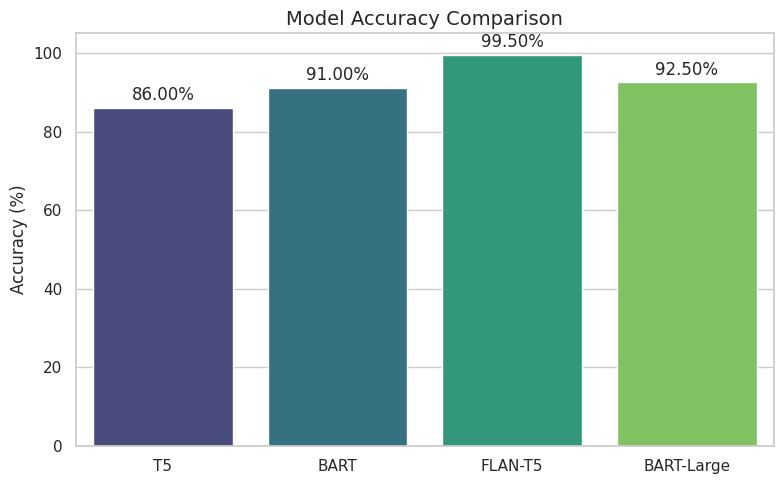

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Accuracy values (in percentages)
model_names = ['T5', 'BART', 'FLAN-T5', 'BART-Large']
accuracies = [86.00, 91.00, 99.50, 92.50]

# Bar Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=accuracies, palette='viridis')

plt.title('Model Accuracy Comparison', fontsize=14)
plt.ylabel('Accuracy (%)')
plt.ylim(0, 105)

# Annotate bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

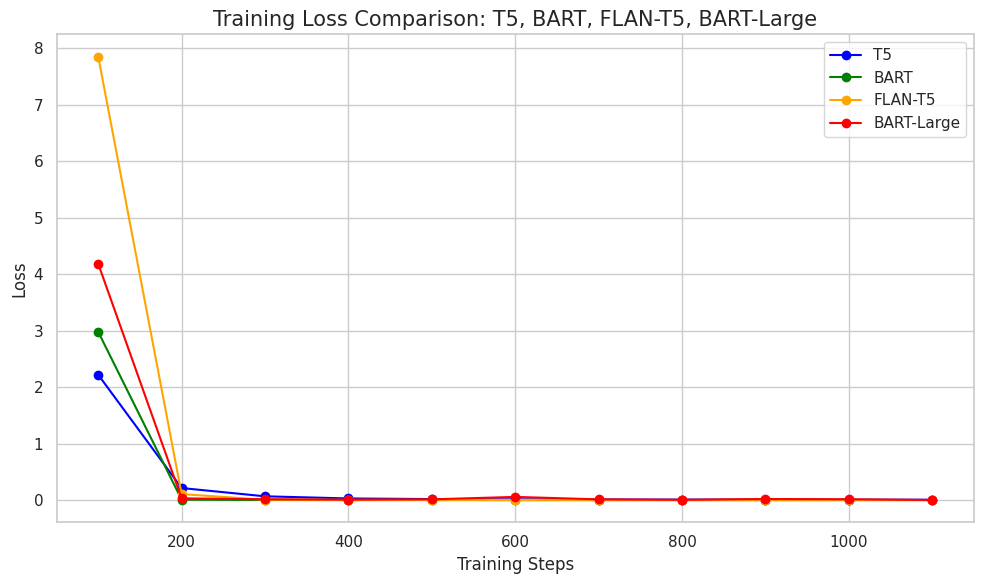

In [13]:
import matplotlib.pyplot as plt

# Step intervals
steps = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100]

# Training losses for each model
t5_loss =        [2.2181, 0.2134, 0.0669, 0.0291, 0.0180, 0.0129, 0.0105, 0.0089, 0.0079, 0.0074, 0.0064]
bart_loss =      [2.9777, 0.0074, 0.0023, 0.0010, 0.0015, 0.0007, 0.0007, 0.0008, 0.0004, 0.0011, 0.0012]
flan_t5_loss =   [7.8493, 0.1061, 0.0061, 0.0032, 0.0022, 0.0017, 0.0011, 0.0010, 0.0009, 0.0009, 0.0009]
bart_large_loss = [4.1820, 0.0308, 0.0152, 0.0081, 0.0132, 0.0566, 0.0128, 0.0047, 0.0196, 0.0144, 0.0014]

# Plot
plt.figure(figsize=(10, 6))

plt.plot(steps, t5_loss, marker='o', label='T5', color='blue')
plt.plot(steps, bart_loss, marker='o', label='BART', color='green')
plt.plot(steps, flan_t5_loss, marker='o', label='FLAN-T5', color='orange')
plt.plot(steps, bart_large_loss, marker='o', label='BART-Large', color='red')

plt.title('Training Loss Comparison: T5, BART, FLAN-T5, BART-Large', fontsize=15)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

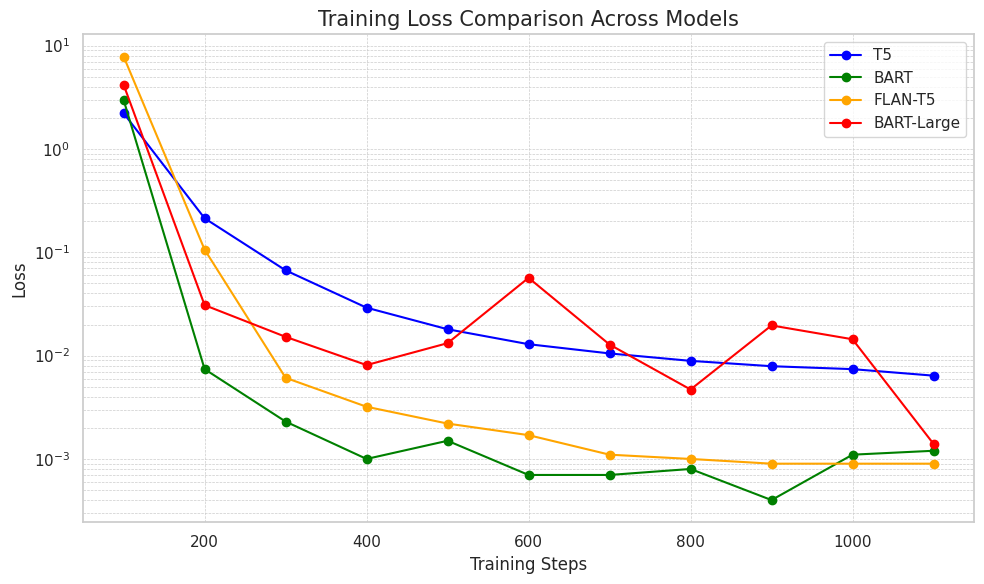

In [14]:
import matplotlib.pyplot as plt

# Step intervals
steps = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100]

# Training losses
t5_loss =        [2.2181, 0.2134, 0.0669, 0.0291, 0.0180, 0.0129, 0.0105, 0.0089, 0.0079, 0.0074, 0.0064]
bart_loss =      [2.9777, 0.0074, 0.0023, 0.0010, 0.0015, 0.0007, 0.0007, 0.0008, 0.0004, 0.0011, 0.0012]
flan_t5_loss =   [7.8493, 0.1061, 0.0061, 0.0032, 0.0022, 0.0017, 0.0011, 0.0010, 0.0009, 0.0009, 0.0009]
bart_large_loss = [4.1820, 0.0308, 0.0152, 0.0081, 0.0132, 0.0566, 0.0128, 0.0047, 0.0196, 0.0144, 0.0014]

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(steps, t5_loss, marker='o', label='T5', color='blue')
plt.plot(steps, bart_loss, marker='o', label='BART', color='green')
plt.plot(steps, flan_t5_loss, marker='o', label='FLAN-T5', color='orange')
plt.plot(steps, bart_large_loss, marker='o', label='BART-Large', color='red')

plt.title('Training Loss Comparison Across Models', fontsize=15)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.yscale('log')  # Logarithmic scale to highlight small differences
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

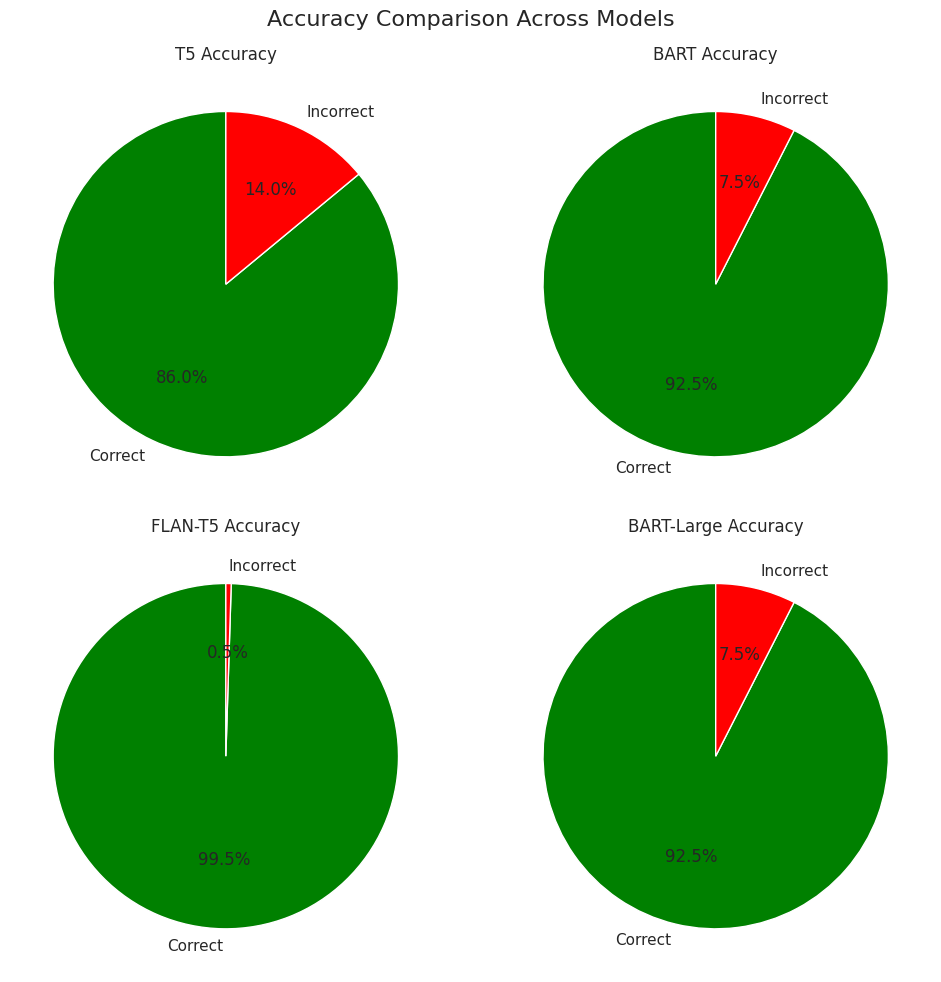

In [15]:
import matplotlib.pyplot as plt

# Total examples used for evaluation
total = 2000

# Correct and incorrect counts
t5_correct = int(0.860 * total)
t5_wrong = total - t5_correct

bart_correct = int(0.925 * total)
bart_wrong = total - bart_correct

flan_t5_correct = int(0.995 * total)
flan_t5_wrong = total - flan_t5_correct

bart_large_correct = int(0.925 * total)
bart_large_wrong = total - bart_large_correct

# Pie chart labels and colors
labels = ['Correct', 'Incorrect']
colors = ['green', 'red']

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# T5
axs[0, 0].pie([t5_correct, t5_wrong], labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
axs[0, 0].set_title('T5 Accuracy')

# BART
axs[0, 1].pie([bart_correct, bart_wrong], labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
axs[0, 1].set_title('BART Accuracy')

# FLAN-T5
axs[1, 0].pie([flan_t5_correct, flan_t5_wrong], labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
axs[1, 0].set_title('FLAN-T5 Accuracy')

# BART-Large
axs[1, 1].pie([bart_large_correct, bart_large_wrong], labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
axs[1, 1].set_title('BART-Large Accuracy')

# Super title and layout
plt.suptitle('Accuracy Comparison Across Models', fontsize=16)
plt.tight_layout()
plt.show()

In [16]:
!pip install gradio transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import gradio as gr
import torch
from transformers import (
    T5Tokenizer, T5ForConditionalGeneration,
    BartTokenizer, BartForConditionalGeneration
)

# Load models from saved directories
t5_tokenizer = T5Tokenizer.from_pretrained("t5_sql_model")
t5_model = T5ForConditionalGeneration.from_pretrained("t5_sql_model")

bart_tokenizer = BartTokenizer.from_pretrained("bart_sql_model")
bart_model = BartForConditionalGeneration.from_pretrained("bart_sql_model")

flan_tokenizer = T5Tokenizer.from_pretrained("flan_t5_sql_model")
flan_model = T5ForConditionalGeneration.from_pretrained("flan_t5_sql_model")

bart_large_tokenizer = BartTokenizer.from_pretrained("bart_large_sql_model")
bart_large_model = BartForConditionalGeneration.from_pretrained("bart_large_sql_model")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
t5_model.to(device)
bart_model.to(device)
flan_model.to(device)
bart_large_model.to(device)

# Inference function
def generate_output(model_name, input_text):
    if model_name == "T5 (t5-small)":
        tokenizer, model = t5_tokenizer, t5_model
    elif model_name == "BART (base)":
        tokenizer, model = bart_tokenizer, bart_model
    elif model_name == "FLAN-T5 (base)":
        tokenizer, model = flan_tokenizer, flan_model
    elif model_name == "BART (large)":
        tokenizer, model = bart_large_tokenizer, bart_large_model
    else:
        return "Invalid model selected."

    input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True).to(device)
    outputs = model.generate(input_ids, max_length=128, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Gradio UI
interface = gr.Interface(
    fn=generate_output,
    inputs=[
        gr.Dropdown(["T5 (t5-small)", "BART (base)", "FLAN-T5 (base)", "BART (large)"], label="Select Model"),
        gr.Textbox(lines=3, placeholder="Enter your query...", label="Input")
    ],
    outputs=gr.Textbox(label="Output"),
    title="SQL Generator using T5 / BART",
    description="Choose a model and enter a natural language question to get SQL output."
)

interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5aad8653957cd24278.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
t5_model.save_pretrained('/content/drive/MyDrive/sql_models/t5_sql_model')
t5_tokenizer.save_pretrained('/content/drive/MyDrive/sql_models/t5_sql_model')

bart_model.save_pretrained('/content/drive/MyDrive/sql_models/bart_sql_model')
bart_tokenizer.save_pretrained('/content/drive/MyDrive/sql_models/bart_sql_model')

flan_model.save_pretrained('/content/drive/MyDrive/sql_models/flan_t5_sql_model')
flan_tokenizer.save_pretrained('/content/drive/MyDrive/sql_models/flan_t5_sql_model')

bart_large_model.save_pretrained('/content/drive/MyDrive/sql_models/bart_large_sql_model')
bart_large_tokenizer.save_pretrained('/content/drive/MyDrive/sql_models/bart_large_sql_model')

('/content/drive/MyDrive/sql_models/bart_large_sql_model/tokenizer_config.json',
 '/content/drive/MyDrive/sql_models/bart_large_sql_model/special_tokens_map.json',
 '/content/drive/MyDrive/sql_models/bart_large_sql_model/vocab.json',
 '/content/drive/MyDrive/sql_models/bart_large_sql_model/merges.txt',
 '/content/drive/MyDrive/sql_models/bart_large_sql_model/added_tokens.json')